<a href="https://colab.research.google.com/github/nilaynishant/AIMLTutorial/blob/main/SemanticSegmentationOnLargeDataset_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --recursive --no-parent https://www.cs.toronto.edu/~vmnih/data/mass_buildings/train/sat/index.html -q
!wget --recursive --no-parent https://www.cs.toronto.edu/~vmnih/data/mass_buildings/train/map/index.html -q

In [ ]:
!pip install split-folders
!pip install focal-loss 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Folder stucture for senmantic segmentation

For semantic segmentation the folder structure needs to look like below
if you want to use ImageDatagenerator.
Data/
    train_images/
                train/
                    img1, img2, img3, ......
    
    train_masks/
                train/
                    msk1, msk, msk3, ......
                    
    val_images/
                val/
                    img1, img2, img3, ......                
    val_masks/
                val/
                    msk1, msk, msk3, ......
      
    test_images/
                test/
                    img1, img2, img3, ......    
                    
    test_masks/
                test/
                    msk1, msk, msk3, ......
Use split-folders library (pip install split-folders) to make this process of splitting
files easy. 

# Model Building


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model




# Creating image generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed=24
batch_size= 8
img_data_gen_args = dict(rescale = 1/255.,
                         rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

mask_data_gen_args = dict(rescale = 1/255.,  #Original pixel values are 0 and 255. So rescaling to 0 to 1
                        rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

#If You need to resize images then add this to the flow_from_directory parameters 
#target_size=(150, 150), #Or whatever the size is for your network

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory("Data/train_images/", 
                                                           seed=seed, 
                                                           batch_size=batch_size,
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays 
                                                                            #thinking class mode is binary.

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory("Data/train_masks/", 
                                                         seed=seed, 
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)


valid_img_generator = image_data_generator.flow_from_directory("Data/val_images/", 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator.flow_from_directory("Data/val_masks/", 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:193: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 110 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
Found 13 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


In [ ]:
train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

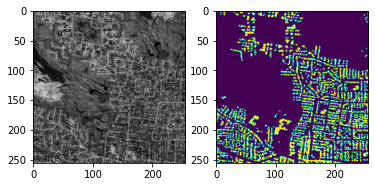

In [ ]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [ ]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]


input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
input_shape

(256, 256, 3)

In [ ]:
from keras import backend as K
#Dice metric can be a great metric to track accuracy of semantic segmentation.
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0
    return 2*intersection / union

In [ ]:
model = build_unet(input_shape)

In [ ]:
from focal_loss import BinaryFocalLoss

In [ ]:
model.compile(optimizer=Adam(lr = 1e-3), loss=BinaryFocalLoss(gamma=2), 
              metrics=[dice_metric])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

In [ ]:
num_train_imgs = len(os.listdir('Data/train_images/train/'))

steps_per_epoch = num_train_imgs //batch_size

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=50)


Epoch 1/50
13/13 [==============================] - 736s 56s/step - loss: 0.1631 - dice_metric: 0.0021 - val_loss: 6.8253 - val_dice_metric: 0.0017
Epoch 2/50
13/13 [==============================] - 738s 57s/step - loss: 0.1219 - dice_metric: 0.0025 - val_loss: 1.4194 - val_dice_metric: 0.0018
Epoch 3/50
13/13 [==============================] - 737s 56s/step - loss: 0.1169 - dice_metric: 0.0026 - val_loss: 2.2640 - val_dice_metric: 0.0016
Epoch 4/50
13/13 [==============================] - 713s 55s/step - loss: 0.1182 - dice_metric: 0.0026 - val_loss: 0.9176 - val_dice_metric: 0.0017
Epoch 5/50
13/13 [==============================] - 718s 55s/step - loss: 0.1145 - dice_metric: 0.0026 - val_loss: 0.3355 - val_dice_metric: 0.0020
Epoch 6/50
13/13 [==============================] - 723s 56s/step - loss: 0.1122 - dice_metric: 0.0026 - val_loss: 0.3828 - val_dice_metric: 0.0016
Epoch 7/50
13/13 [==============================] - 728s 57s/step - loss: 0.1154 - dice_metric: 0.0027 - val_los